<a href="https://colab.research.google.com/github/amar9929-3/Bioinformatics_Project/blob/main/Notebooks/ML_Christian_Finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup and Imports

In [59]:
# If running on Colab, install anything missing
try:
    import umap
except Exception:
    %pip -q install umap-learn scikit-learn matplotlib pandas numpy

In [60]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Simulated Data

In [61]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('simulated_group_conditioned.csv')
df.head()

Saving simulated_group_conditioned.csv to simulated_group_conditioned.csv


,@#,River,Predation,Population,Lengthmm,Weightg,BMI,EyeSizemm,InternalParasite#,BrainWeightg
0,AR.HP.25,EC,KO,AMHP,42,0.166140,0.841119,2.166681,4,0.006072
1,AM.RO.17,AP,HP,APHP,29,0.083000,0.754529,1.535650,3,0.003208
2,AM.RO.01,AP,KO,APHP,46,0.588084,0.968317,2.845715,3,0.009100
3,AR.RO.25,AM,KO,APHP,22,0.083000,0.830582,1.674321,2,0.004103
4,AR.HP.10,AP,KO,APKO,36,0.390498,0.839801,1.775865,0,0.006911


## Train/Test Split

In [62]:
cols_to_drop = ['@#', 'River', 'Predation', 'Population', 'Lengthmm', 'Weightg']
X = df.drop(columns=cols_to_drop)
y = df['Population']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

## Normalizing Data

In [63]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

def make_preprocess():
    return ColumnTransformer(
        transformers=[
            (
                'num',
                Pipeline([
                    ('log', FunctionTransformer(np.log1p, validate=False)),
                    ('scale', StandardScaler())
                ]),
                numeric_cols
            )
        ],
        remainder='drop'
    )

# Running Unsupervised Methods for Visualization

## Log Tranform for Visualization

In [64]:
pre_vis = make_preprocess()
Xtr_proc = pre_vis.fit_transform(X_train)
Xte_proc = pre_vis.transform(X_test)

ytr = y_train.values
yte = y_test.values

## PCA

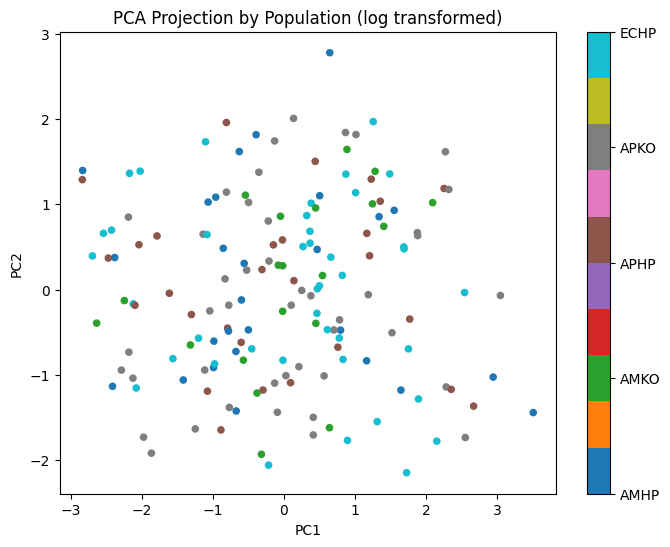

In [65]:
# PCA
pca = PCA(n_components=2)
Xtr_pca = pca.fit_transform(Xtr_proc)
Xte_pca = pca.transform(Xte_proc)

# Encode labels
le = LabelEncoder()
ytr_encoded = le.fit_transform(ytr)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(Xtr_pca[:, 0], Xtr_pca[:, 1], c=ytr_encoded, cmap='tab10', s=20)

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(le.classes_)))
cbar.set_ticklabels(le.classes_)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection by Population (log transformed)")
plt.show()

## UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


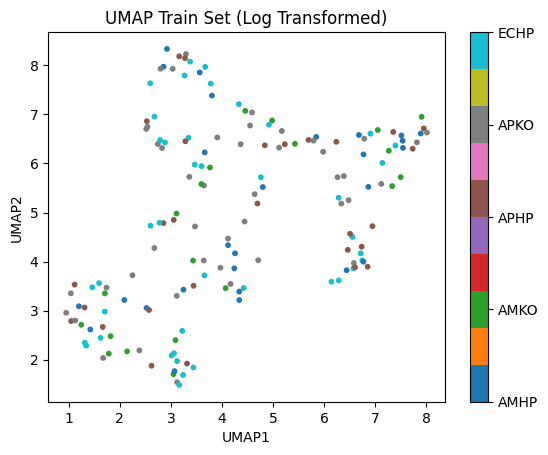

In [66]:
# UMAP
um = umap.UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=15, min_dist=0.1)
UM_tr = um.fit_transform(Xtr_proc)
UM_te = um.transform(Xte_proc)

# Plot
plt.figure()
scatter = plt.scatter(UM_tr[:, 0], UM_tr[:, 1], c=ytr_encoded, cmap='tab10', s=10)
plt.title("UMAP Train Set (Log Transformed)")

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(le.classes_)))
cbar.set_ticklabels(le.classes_)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

## t-SNE

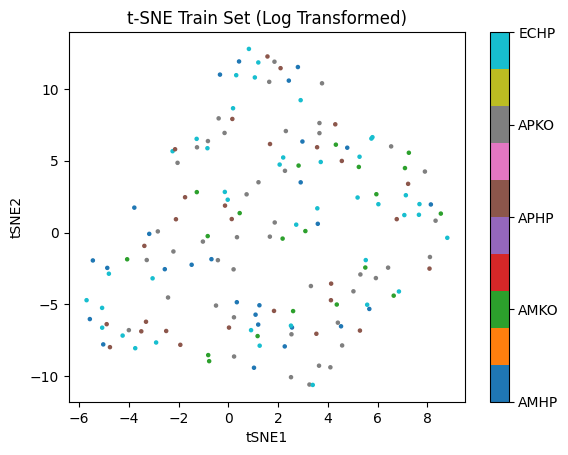

In [67]:
# t-SNE
ts = TSNE(n_components=2, random_state=RANDOM_STATE, init="pca", learning_rate="auto", perplexity=30)
TS_tr = ts.fit_transform(Xtr_proc)

# Plot
plt.figure()
scatter = plt.scatter(TS_tr[:,0], TS_tr[:,1], c=ytr_encoded, cmap='tab10', s=5)

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(le.classes_)))
cbar.set_ticklabels(le.classes_)

plt.title("t-SNE Train Set (Log Transformed)")
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.show()

# Build and Train Supervised Pipelines

In [68]:
models = {
    "LogReg": Pipeline([
        ("preprocess", make_preprocess()),
        ("clf", LogisticRegression(max_iter=500, multi_class="auto"))
    ]),

    "RF": Pipeline([
        ("preprocess", make_preprocess()),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
    ]),

    "SVM": Pipeline([
        ("preprocess", make_preprocess()),
        ("clf", SVC(kernel='rbf', probability=True))
    ])
}


results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)

    acc = accuracy_score(y_test, pred)

    try:
        auc = roc_auc_score(y_test, proba, multi_class="ovr")
    except:
        auc = np.nan

    results[name] = {"accuracy": acc, "roc_auc_ovr": auc}

results_df = pd.DataFrame(results).T
print("Baseline Train/Test Results")
print(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline Train/Test Results
        accuracy  roc_auc_ovr
LogReg  0.206897     0.353905
RF      0.172414     0.424496
SVM     0.241379     0.573130


# Confusion Matrix of the Best Model

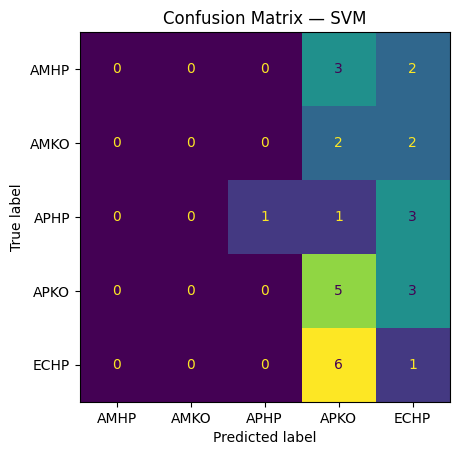

              precision    recall  f1-score   support

        AMHP       0.00      0.00      0.00         5
        APKO       0.00      0.00      0.00         4
        APHP       1.00      0.20      0.33         5
        ECHP       0.29      0.62      0.40         8
        AMKO       0.09      0.14      0.11         7

    accuracy                           0.24        29
   macro avg       0.28      0.19      0.17        29
weighted avg       0.28      0.24      0.19        29



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
best = max(results.items(), key=lambda kv: kv[1]["accuracy"])[0]
best_pipe = models[best]
pred = best_pipe.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=sorted(y_test.unique()))
fig, ax = plt.subplots()
disp.plot(ax=ax, colorbar=False)
plt.title(f"Confusion Matrix — {best}")
plt.show()

print(classification_report(y_test, pred, target_names=y_test.unique()))

# Cross-Validate Training

In [70]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {
    "LogReg": {"clf__C":[0.1,1,10]},
    "RF":     {"clf__n_estimators":[200,400], "clf__max_depth":[None,10]},
    "SVM":    {"clf__C":[0.5,1,2], "clf__gamma":["scale","auto"]},
}

tuned = {}
for name, pipe in models.items():
    grid_pipe = Pipeline([
      ("preprocess", make_preprocess()),
      ("clf", pipe.named_steps["clf"])
    ])

    grid = GridSearchCV(grid_pipe, param_grid[name], cv=cv, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    tuned[name] = {"best_score": grid.best_score_, "best_params": grid.best_params_, "estimator": grid.best_estimator_}

pd.DataFrame({k: {"cv_best_acc": v["best_score"], **v["best_params"]} for k,v in tuned.items()}).T

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,cv_best_acc,clf__C,clf__max_depth,clf__n_estimators,clf__gamma
LogReg,0.2625,0.1,NaN,NaN,NaN
RF,0.2125,NaN,NaN,400.0,NaN
SVM,0.29375,0.5,NaN,NaN,scale


# ROC Curves

<Figure size 640x480 with 0 Axes>

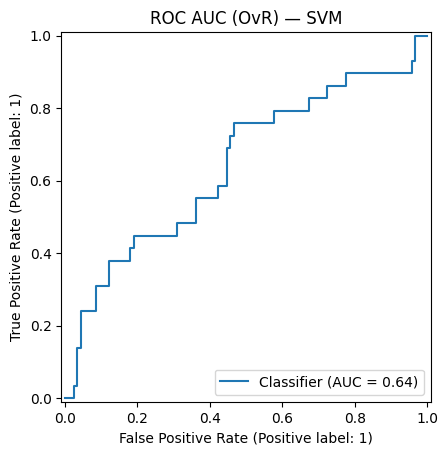

In [71]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

best_name = max(tuned.items(), key=lambda kv: kv[1]["best_score"])[0]
est = tuned[best_name]["estimator"].fit(X_train, y_train)
y_score = est.predict_proba(X_test)

y_bin = label_binarize(y_test, classes=np.unique(y_train))
fig = plt.figure()
RocCurveDisplay.from_predictions(y_bin.ravel(), y_score.ravel())
plt.title(f"ROC AUC (OvR) — {best_name}")
plt.show()

# Trained Color Coded UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


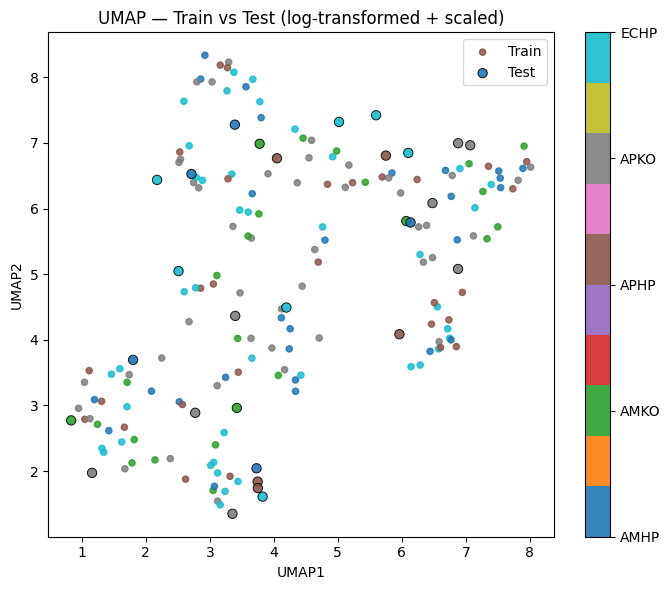

In [72]:
# Encode labels for coloring
le = LabelEncoder()
ytr_enc = le.fit_transform(y_train)
yte_enc = le.transform(y_test)

# Fit UMAP on TRAIN (using preprocessed data)
um_vis = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=15,
    min_dist=0.1
)

UM_tr = um_vis.fit_transform(Xtr_proc)   # preprocessed TRAIN
UM_te = um_vis.transform(Xte_proc)       # preprocessed TEST

# Plot
plt.figure(figsize=(7,6))

# TRAIN (solid)
plt.scatter(
    UM_tr[:,0], UM_tr[:,1],
    c=ytr_enc, cmap='tab10', s=20, alpha=0.85,
    label="Train"
)

# TEST (hollow)
plt.scatter(
    UM_te[:,0], UM_te[:,1],
    c=yte_enc, cmap='tab10', s=45, alpha=0.9,
    facecolors='none', edgecolors='k', linewidths=0.7,
    label="Test"
)

# Colorbar with labels
cbar = plt.colorbar()
cbar.set_ticks(range(len(le.classes_)))
cbar.set_ticklabels(le.classes_)

plt.title("UMAP — Train vs Test (log-transformed + scaled)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.tight_layout()
plt.show()

# Final Analysis with Most Accurate Classifier (SVM)

## Real Data

In [73]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
dn = pd.read_csv('Anne 3.3.csv')
dn.head()

Saving Anne 3.3.csv to Anne 3.3.csv


,@#,River,Predation,Population,Lengthmm,Weightg,BMI,EyeSizemm,InternalParasite#,BrainWeightg
0,AR.RO.01,AP,KO,APKO,36,0.484,1.037380,2.296,0,0.0096
1,AR.RO.02,AP,KO,APKO,34,0.390,0.992265,2.198,2,0.0068
2,AR.RO.03,AP,KO,APKO,36,0.427,0.915209,2.298,28,0.0081
3,AR.RO.04,AP,KO,APKO,42,0.619,0.835493,2.875,1,0.0088
4,AR.RO.05,AP,KO,APKO,49,0.994,0.844886,2.830,0,0.0100


## Split Real Data

In [74]:
X_new = dn.drop(columns=cols_to_drop)
y_new = dn['Population']

sample = X_new.sample(frac=0.15, random_state=42)
X_15 = sample
y_15 = y_new.loc[sample.index]

## Most Accurate Classifier; SVM

In [76]:
# Choose Most Accurate Classifier -> SVM
best_name = max(results.items(), key=lambda kv: kv[1]["accuracy"])[0]
best_pipe = models[best_name]

print("Best model from training:", best_name)

pred_new = best_pipe.predict(X_new)
proba_new = best_pipe.predict_proba(X_new)

# Evaluation table
if y_new is not None:
    acc = accuracy_score(y_new, pred_new)
    try:
        auc = roc_auc_score(y_new, proba_new, multi_class="ovr")
    except:
        auc = np.nan
else:
    acc = np.nan
    auc = np.nan

results_new_df = pd.DataFrame({
    best_name: {
        "accuracy": acc,
        "roc_auc_ovr": auc
    }
}).T

print("Real Data Results (Best Model Only)")
print(results_new_df)

Best model from training: SVM
Real Data Results (Best Model Only)
     accuracy  roc_auc_ovr
SVM  0.222222     0.509502
